In [1]:
import os
import pandas as pd
import numpy as np
import requests
import json
import yfinance as yf
import seaborn as sns
from dotenv import load_dotenv
from openai import OpenAI
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [2]:
# Load .env file
load_dotenv()

True

In [3]:
# Check if the environment variable is set for Open AI API
api_key = os.getenv("OPENAI_API_KEY")
if api_key is None:
    raise ValueError("The environment variable 'OPENAI_API_KEY' is not set.")

In [4]:
# Check if the environment variable is set for Vantage API
van_api_key = os.getenv("VANTAGE_API_KEY")
if van_api_key is None:
    raise ValueError("The environment variable 'VANTAGE_API_KEY' is not set.")

In [5]:
# Stock symbol for S&P 500
symbol = "SPY"

# API URL for real-time stock data
stock_url = f"https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol={symbol}&outputsize=full&apikey={van_api_key}"

# Fetch stock data
response = requests.get(stock_url)

stock_data = response.json()

print(stock_data)

{'Meta Data': {'1. Information': 'Daily Prices (open, high, low, close) and Volumes', '2. Symbol': 'SPY', '3. Last Refreshed': '2025-03-13', '4. Output Size': 'Full size', '5. Time Zone': 'US/Eastern'}, 'Time Series (Daily)': {'2025-03-13': {'1. open': '558.4900', '2. high': '559.1050', '3. low': '549.6800', '4. close': '551.4200', '5. volume': '74079414'}, '2025-03-12': {'1. open': '562.1700', '2. high': '563.1100', '3. low': '553.6900', '4. close': '558.8700', '5. volume': '69588167'}, '2025-03-11': {'1. open': '559.4000', '2. high': '564.0200', '3. low': '552.0200', '4. close': '555.9200', '5. volume': '88102109'}, '2025-03-10': {'1. open': '567.5900', '2. high': '569.5400', '3. low': '555.5900', '4. close': '560.5800', '5. volume': '97084529'}, '2025-03-07': {'1. open': '570.9000', '2. high': '577.3900', '3. low': '565.6300', '4. close': '575.9200', '5. volume': '81158816'}, '2025-03-06': {'1. open': '575.4800', '2. high': '580.1736', '3. low': '570.1200', '4. close': '572.7100', '

In [6]:
# Extract time series data
time_series = stock_data["Time Series (Daily)"]
# Prints daily stock price data
print(time_series)

{'2025-03-13': {'1. open': '558.4900', '2. high': '559.1050', '3. low': '549.6800', '4. close': '551.4200', '5. volume': '74079414'}, '2025-03-12': {'1. open': '562.1700', '2. high': '563.1100', '3. low': '553.6900', '4. close': '558.8700', '5. volume': '69588167'}, '2025-03-11': {'1. open': '559.4000', '2. high': '564.0200', '3. low': '552.0200', '4. close': '555.9200', '5. volume': '88102109'}, '2025-03-10': {'1. open': '567.5900', '2. high': '569.5400', '3. low': '555.5900', '4. close': '560.5800', '5. volume': '97084529'}, '2025-03-07': {'1. open': '570.9000', '2. high': '577.3900', '3. low': '565.6300', '4. close': '575.9200', '5. volume': '81158816'}, '2025-03-06': {'1. open': '575.4800', '2. high': '580.1736', '3. low': '570.1200', '4. close': '572.7100', '5. volume': '80094868'}, '2025-03-05': {'1. open': '576.6900', '2. high': '584.8800', '3. low': '573.0795', '4. close': '583.0600', '5. volume': '71230528'}, '2025-03-04': {'1. open': '579.7100', '2. high': '585.3900', '3. low

In [7]:
# Convert to DataFrame
df = pd.DataFrame.from_dict(time_series, orient="index")
df

,1. open,2. high,3. low,4. close,5. volume
2025-03-13,558.4900,559.1050,549.6800,551.4200,74079414
2025-03-12,562.1700,563.1100,553.6900,558.8700,69588167
2025-03-11,559.4000,564.0200,552.0200,555.9200,88102109
2025-03-10,567.5900,569.5400,555.5900,560.5800,97084529
2025-03-07,570.9000,577.3900,565.6300,575.9200,81158816
...,...,...,...,...,...
1999-11-05,138.6250,139.1093,136.7812,137.8750,7431500
1999-11-04,136.7500,137.3593,135.7656,136.5312,7907500
1999-11-03,136.0000,136.3750,135.1250,135.5000,7222300
1999-11-02,135.9687,137.2500,134.5937,134.5937,6516900


In [8]:
# Rename columns for readability
df.columns = ["open", "high", "low", "close", "volume"]
df

,open,high,low,close,volume
2025-03-13,558.4900,559.1050,549.6800,551.4200,74079414
2025-03-12,562.1700,563.1100,553.6900,558.8700,69588167
2025-03-11,559.4000,564.0200,552.0200,555.9200,88102109
2025-03-10,567.5900,569.5400,555.5900,560.5800,97084529
2025-03-07,570.9000,577.3900,565.6300,575.9200,81158816
...,...,...,...,...,...
1999-11-05,138.6250,139.1093,136.7812,137.8750,7431500
1999-11-04,136.7500,137.3593,135.7656,136.5312,7907500
1999-11-03,136.0000,136.3750,135.1250,135.5000,7222300
1999-11-02,135.9687,137.2500,134.5937,134.5937,6516900


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6380 entries, 2025-03-13 to 1999-11-01
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   open    6380 non-null   object
 1   high    6380 non-null   object
 2   low     6380 non-null   object
 3   close   6380 non-null   object
 4   volume  6380 non-null   object
dtypes: object(5)
memory usage: 299.1+ KB


In [10]:
# Convert data types
df = df.astype(float)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6380 entries, 2025-03-13 to 1999-11-01
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    6380 non-null   float64
 1   high    6380 non-null   float64
 2   low     6380 non-null   float64
 3   close   6380 non-null   float64
 4   volume  6380 non-null   float64
dtypes: float64(5)
memory usage: 299.1+ KB


In [12]:
# Reset index to make the date a column
df = df.reset_index()

In [13]:
# Rename the new column to "date" (if it’s not automatically named)
df = df.rename(columns={"index": "date"})
df

,date,open,high,low,close,volume
0,2025-03-13,558.4900,559.1050,549.6800,551.4200,74079414.0
1,2025-03-12,562.1700,563.1100,553.6900,558.8700,69588167.0
2,2025-03-11,559.4000,564.0200,552.0200,555.9200,88102109.0
3,2025-03-10,567.5900,569.5400,555.5900,560.5800,97084529.0
4,2025-03-07,570.9000,577.3900,565.6300,575.9200,81158816.0
...,...,...,...,...,...,...
6375,1999-11-05,138.6250,139.1093,136.7812,137.8750,7431500.0
6376,1999-11-04,136.7500,137.3593,135.7656,136.5312,7907500.0
6377,1999-11-03,136.0000,136.3750,135.1250,135.5000,7222300.0
6378,1999-11-02,135.9687,137.2500,134.5937,134.5937,6516900.0


In [14]:
# Convert to datetime format (recommended)
df["date"] = pd.to_datetime(df["date"])

# Display the DataFrame
df

,date,open,high,low,close,volume
0,2025-03-13,558.4900,559.1050,549.6800,551.4200,74079414.0
1,2025-03-12,562.1700,563.1100,553.6900,558.8700,69588167.0
2,2025-03-11,559.4000,564.0200,552.0200,555.9200,88102109.0
3,2025-03-10,567.5900,569.5400,555.5900,560.5800,97084529.0
4,2025-03-07,570.9000,577.3900,565.6300,575.9200,81158816.0
...,...,...,...,...,...,...
6375,1999-11-05,138.6250,139.1093,136.7812,137.8750,7431500.0
6376,1999-11-04,136.7500,137.3593,135.7656,136.5312,7907500.0
6377,1999-11-03,136.0000,136.3750,135.1250,135.5000,7222300.0
6378,1999-11-02,135.9687,137.2500,134.5937,134.5937,6516900.0


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6380 entries, 0 to 6379
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    6380 non-null   datetime64[ns]
 1   open    6380 non-null   float64       
 2   high    6380 non-null   float64       
 3   low     6380 non-null   float64       
 4   close   6380 non-null   float64       
 5   volume  6380 non-null   float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 299.2 KB


In [16]:
df.isnull().sum()

date      0
open      0
high      0
low       0
close     0
volume    0
dtype: int64

In [17]:
df.describe()

,date,open,high,low,close,volume
count,6380,6380.000000,6380.000000,6380.000000,6380.000000,6.380000e+03
mean,2012-07-06 16:06:41.755485952,213.494536,214.730116,212.131175,213.502096,1.049347e+08
min,1999-11-01 00:00:00,67.950000,70.000000,67.100000,68.110000,1.708170e+05
25%,2006-03-07 18:00:00,120.580000,121.327500,119.910000,120.627500,4.945280e+07
50%,2012-07-05 12:00:00,149.328100,150.290000,148.311850,149.370000,7.796863e+07
75%,2018-11-05 06:00:00,277.122500,278.590000,275.342500,277.010000,1.338051e+08
max,2025-03-13 00:00:00,611.540000,613.230000,609.560000,612.930000,8.710263e+08
std,NaN,127.457394,128.031375,126.791803,127.465606,9.075252e+07


In [18]:
# Correlation between the variable
corr_matrix = df[['open', 'high', 'low', 'close', 'volume']].corr()
corr_matrix

,open,high,low,close,volume
open,1.000000,0.999943,0.999923,0.999869,-0.208834
high,0.999943,1.000000,0.999881,0.999918,-0.206435
low,0.999923,0.999881,1.000000,0.999931,-0.212304
close,0.999869,0.999918,0.999931,1.000000,-0.209709
volume,-0.208834,-0.206435,-0.212304,-0.209709,1.000000


<Axes: >

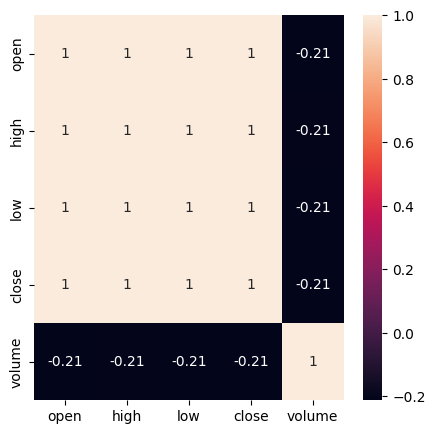

In [19]:
# Visualize the correlation matrix
plt.figure(figsize=(5,5))
sns.heatmap(corr_matrix, annot=True)

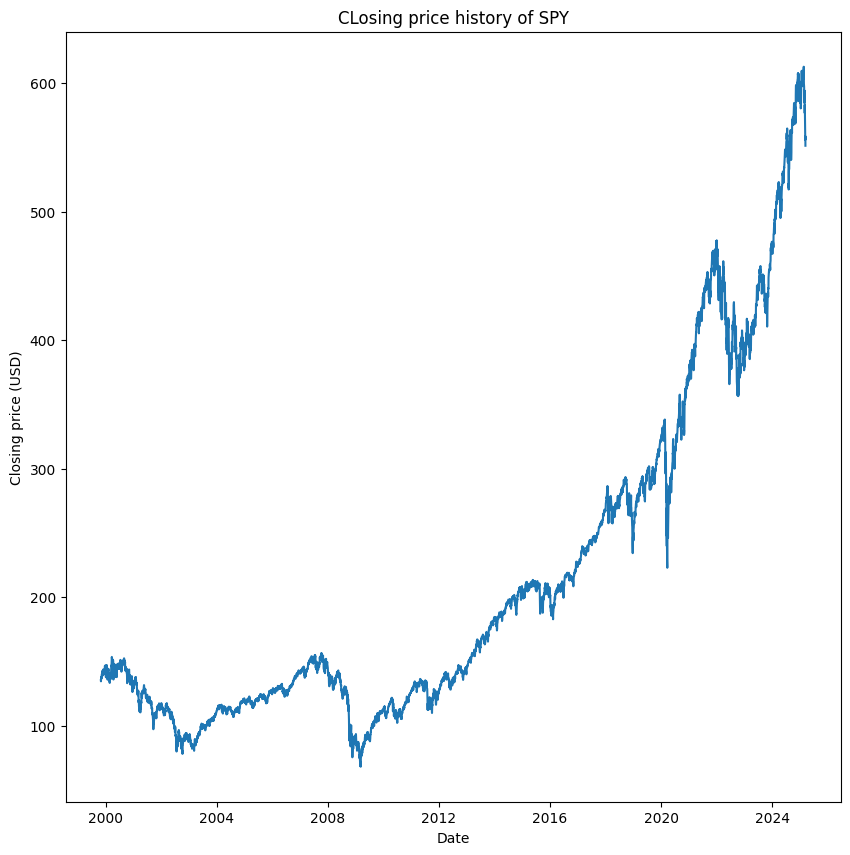

In [20]:
# Visualization of the closing price and the date
plt.figure(figsize=(10,10))
plt.title('CLosing price history of SPY')
plt.plot(df['date'], df['close'])
plt.xlabel('Date')
plt.ylabel('Closing price (USD)')
plt.show()

In [21]:
df.head()

,date,open,high,low,close,volume
0,2025-03-13,558.49,559.105,549.68,551.42,74079414.0
1,2025-03-12,562.17,563.110,553.69,558.87,69588167.0
2,2025-03-11,559.40,564.020,552.02,555.92,88102109.0
3,2025-03-10,567.59,569.540,555.59,560.58,97084529.0
4,2025-03-07,570.90,577.390,565.63,575.92,81158816.0


In [22]:
# Build the machine learning algorithm
X = df[['open', 'high', 'low', 'volume']].values
y = df['close'].values

In [23]:
# Data spliting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [24]:
X_train

array([[1.25550000e+02, 1.26500000e+02, 1.24850000e+02, 9.78220000e+06],
       [1.40300000e+02, 1.40740000e+02, 1.39940000e+02, 6.91742000e+07],
       [1.27160000e+02, 1.28640000e+02, 1.26190000e+02, 3.33657698e+08],
       ...,
       [1.12980000e+02, 1.13580000e+02, 1.12710000e+02, 3.27395000e+07],
       [1.04880000e+02, 1.05220000e+02, 1.03830000e+02, 4.00665000e+07],
       [4.38390000e+02, 4.41680000e+02, 4.38200000e+02, 7.24374990e+07]])

In [25]:
# Feature scaling
# Standard scaler - mean of 0 and a standard deviation of 1
# Minmaxscaler 
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [26]:
# Multi linear regression
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

LinearRegression()

In [27]:
# Prediction on the test set
y_pred_mlr = lin_reg.predict(X_test)

In [28]:
# Put in a dataframe
pd.DataFrame({'Actual value': y_test, 'Predicted value': y_pred_mlr})

,Actual value,Predicted value
0,145.3700,145.110019
1,116.5500,116.287118
2,209.6200,209.253988
3,311.3600,311.163340
4,112.6000,113.111141
...,...,...
1271,134.9000,134.187279
1272,141.5600,141.913846
1273,148.5625,148.905198
1274,91.2400,91.513292


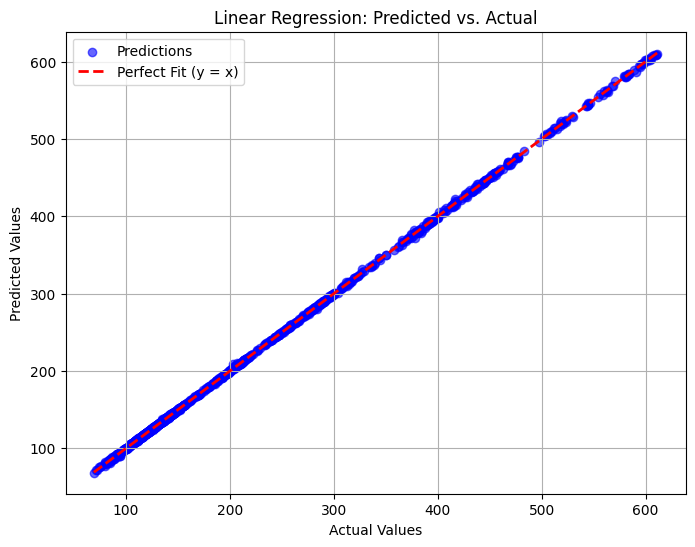

In [29]:

# Plot Actual vs. Predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_mlr, alpha=0.6, color='blue', label='Predictions')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='dashed', linewidth=2, label="Perfect Fit (y = x)")
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Linear Regression: Predicted vs. Actual')
plt.legend()
plt.grid(True)
plt.show()


In [30]:
# model evaluation: LinearRegression
# r2, mean absolute error, mean square error, root mean square error
# 0, 1
# mae must have a lower mae 0. 
# mse --o.
# rmse 0. 
r2 = metrics.r2_score(y_test, y_pred_mlr)
meanABerr = metrics.mean_absolute_error(y_test, y_pred_mlr)
meanSqErr = metrics.mean_squared_error(y_test, y_pred_mlr)
rootMeanSqErr = np.sqrt(metrics.mean_squared_error(y_test, y_pred_mlr))
print('R2:',r2)
print('Mean Absolute Error:',meanABerr)
print('Mean Square Error:',meanSqErr)
print('Root Mean Square Error:',rootMeanSqErr)

R2: 0.9999459941362747
Mean Absolute Error: 0.6189459797432957
Mean Square Error: 0.9489016145958695
Root Mean Square Error: 0.9741158116958525


In [31]:
# Support vector regression
# Radial basis function
svr = SVR(kernel = 'linear')
svr.fit(X_train, y_train)

SVR(kernel='linear')

In [32]:
# Prediction on the test data
y_pred_svr = svr.predict(X_test)

In [33]:
# Put in a dataframe
pd.DataFrame({'Actual value': y_test, 'Predicted value': y_pred_svr})

,Actual value,Predicted value
0,145.3700,144.514671
1,116.5500,115.542852
2,209.6200,207.300141
3,311.3600,311.211937
4,112.6000,113.054529
...,...,...
1271,134.9000,134.499512
1272,141.5600,142.860114
1273,148.5625,149.297293
1274,91.2400,91.555581


In [34]:
# Model evaluation: SVR
# r2, mean absolute error, mean square error, root mean square error
# 0, 1
# mae must have a lower mae 0. 
# mse --o.
# rmse 0. 
r2 = metrics.r2_score(y_test, y_pred_svr)
meanABerr = metrics.mean_absolute_error(y_test, y_pred_svr)
meanSqErr = metrics.mean_squared_error(y_test, y_pred_svr)
rootMeanSqErr = np.sqrt(metrics.mean_squared_error(y_test, y_pred_svr))
print('R2:',r2)
print('Mean Absolute Error:',meanABerr)
print('Mean Square Error:',meanSqErr)
print('Root Mean Square Error:',rootMeanSqErr)

R2: 0.9998781698281588
Mean Absolute Error: 0.919623714006154
Mean Square Error: 2.140598053474187
Root Mean Square Error: 1.4630782800227018


In [35]:
# random forest regression
reg = RandomForestRegressor(n_estimators=10)
reg.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10)

In [36]:
# prediction on the test data
y_pred_rf = reg.predict(X_test)

In [37]:
# put in a dataframe
pd.DataFrame({'Actual value': y_test, 'Predicted value': y_pred_rf })

,Actual value,Predicted value
0,145.3700,144.73774
1,116.5500,115.80600
2,209.6200,207.50600
3,311.3600,311.16000
4,112.6000,113.38500
...,...,...
1271,134.9000,134.57200
1272,141.5600,142.29573
1273,148.5625,149.09355
1274,91.2400,91.61900


In [38]:
# Model evaluation: RandomForestRegressor
# r2, mean absolute error, mean square error, root mean square error
# 0, 1
# mae must have a lower mae 0. 
# mse --o.
# rmse 0. 
r2 = metrics.r2_score(y_test, y_pred_rf)
meanABerr = metrics.mean_absolute_error(y_test, y_pred_rf)
meanSqErr = metrics.mean_squared_error(y_test, y_pred_rf)
rootMeanSqErr = np.sqrt(metrics.mean_squared_error(y_test, y_pred_rf))
print('R2:',r2)
print('Mean Absolute Error:',meanABerr)
print('Mean Square Error:',meanSqErr)
print('Root Mean Square Error:',rootMeanSqErr)

R2: 0.9998914800399598
Mean Absolute Error: 0.8440255172413798
Mean Square Error: 1.9067330507255507
Root Mean Square Error: 1.380845049498875



R² Scores:
                            Standard Scaler  Min-Max Scaler  Robust Scaler
Linear Regression                 0.999946        0.999946       0.999946
Support Vector Regression         0.999878        0.999860       0.999874
RandomForestRegression            0.999889        0.999889       0.999889
XGBoost Regression                0.999808        0.999808       0.999808

Mean Squared Errors (MSE):
                            Standard Scaler  Min-Max Scaler  Robust Scaler
Linear Regression                 0.948902        0.948902       0.948902
Support Vector Regression         2.140598        2.466673       2.222034
RandomForestRegression            1.951930        1.953165       1.953533
XGBoost Regression                3.374299        3.374299       3.374299

Root Mean Squared Errors (RMSE):
                            Standard Scaler  Min-Max Scaler  Robust Scaler
Linear Regression                 0.974116        0.974116       0.974116
Support Vector Regression         1

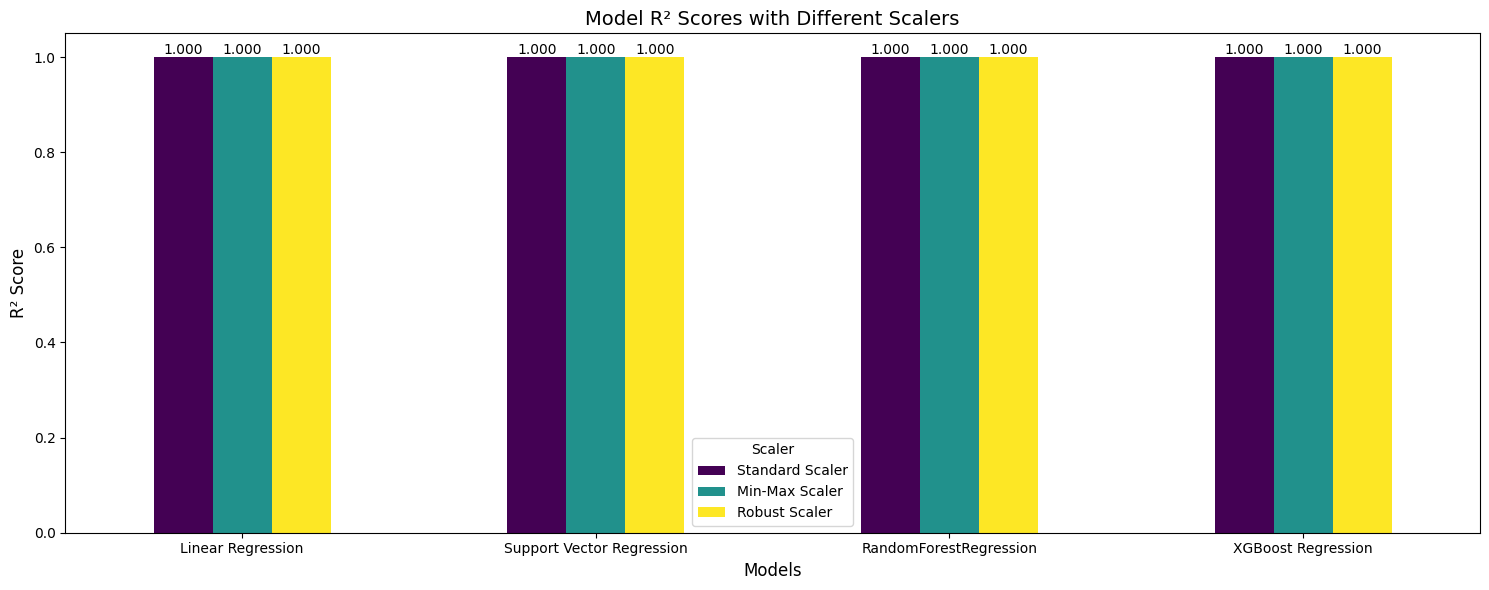

In [39]:


# Define scalers
scalers = {
    "Standard Scaler": StandardScaler(),
    "Min-Max Scaler": MinMaxScaler(),
    "Robust Scaler": RobustScaler()
}

# Initialize models
models = {
    "Linear Regression": LinearRegression(),
    "Support Vector Regression": SVR(kernel='linear'),
    "RandomForestRegression": RandomForestRegressor(n_estimators=10, random_state=42),
    "XGBoost Regression": XGBRegressor(n_estimators=100, seed=42)
}

# Dictionary to store all results
all_results = {}

# Iterate through each scaler and evaluate models
for scaler_name, scaler in scalers.items():
    results = {"R² Score": {}, "MSE": {}, "RMSE": {}}
    
    for model_name, model in models.items():
        pipeline = Pipeline([
            ('scaler', scaler),
            ('model', model)
        ])
        pipeline.fit(X_train, y_train)
        predictions = pipeline.predict(X_test)
        
        # Compute metrics
        r2 = r2_score(y_test, predictions)
        mse = mean_squared_error(y_test, predictions)
        rmse = np.sqrt(mse)
        
        # Store results
        results["R² Score"][model_name] = r2
        results["MSE"][model_name] = mse
        results["RMSE"][model_name] = rmse
    
    all_results[scaler_name] = results

# Convert results to DataFrame format for R² Score
r2_df = pd.DataFrame({scaler: all_results[scaler]["R² Score"] for scaler in scalers})
mse_df = pd.DataFrame({scaler: all_results[scaler]["MSE"] for scaler in scalers})
rmse_df = pd.DataFrame({scaler: all_results[scaler]["RMSE"] for scaler in scalers})

# Print DataFrames
print("\nR² Scores:\n", r2_df)
print("\nMean Squared Errors (MSE):\n", mse_df)
print("\nRoot Mean Squared Errors (RMSE):\n", rmse_df)

# Plotting R² Scores
ax = r2_df.plot(kind='bar', figsize=(15, 6), colormap='viridis')
plt.title('Model R² Scores with Different Scalers', fontsize=14)
plt.ylabel('R² Score', fontsize=12)
plt.xlabel('Models', fontsize=12)
plt.xticks(rotation=0)
plt.legend(title="Scaler", fontsize=10)

# Add text labels on top of each bar
for container in ax.containers:
    ax.bar_label(container, fmt='%.3f', label_type='edge', fontsize=10)

plt.tight_layout()
plt.show()


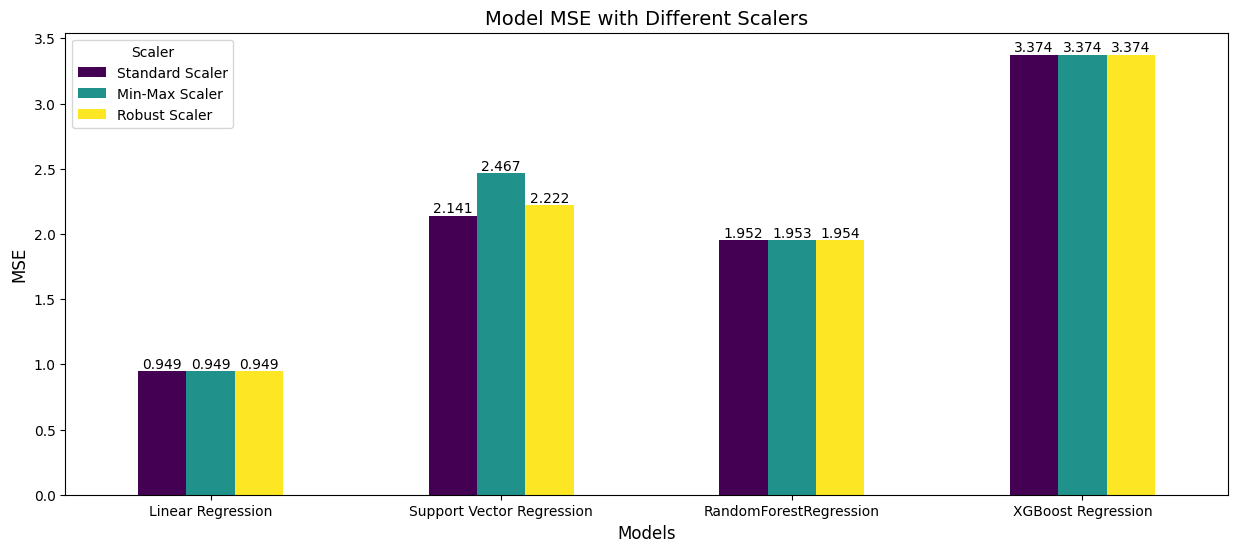

In [40]:
# Plotting MSE Scores
ax = mse_df.plot(kind='bar', figsize=(15, 6), colormap='viridis')
plt.title('Model MSE with Different Scalers', fontsize=14)
plt.ylabel('MSE', fontsize=12)
plt.xlabel('Models', fontsize=12)
plt.xticks(rotation=0)
plt.legend(title="Scaler", fontsize=10)

# Add text labels on top of each bar
for container in ax.containers:
    ax.bar_label(container, fmt='%.3f', label_type='edge', fontsize=10)

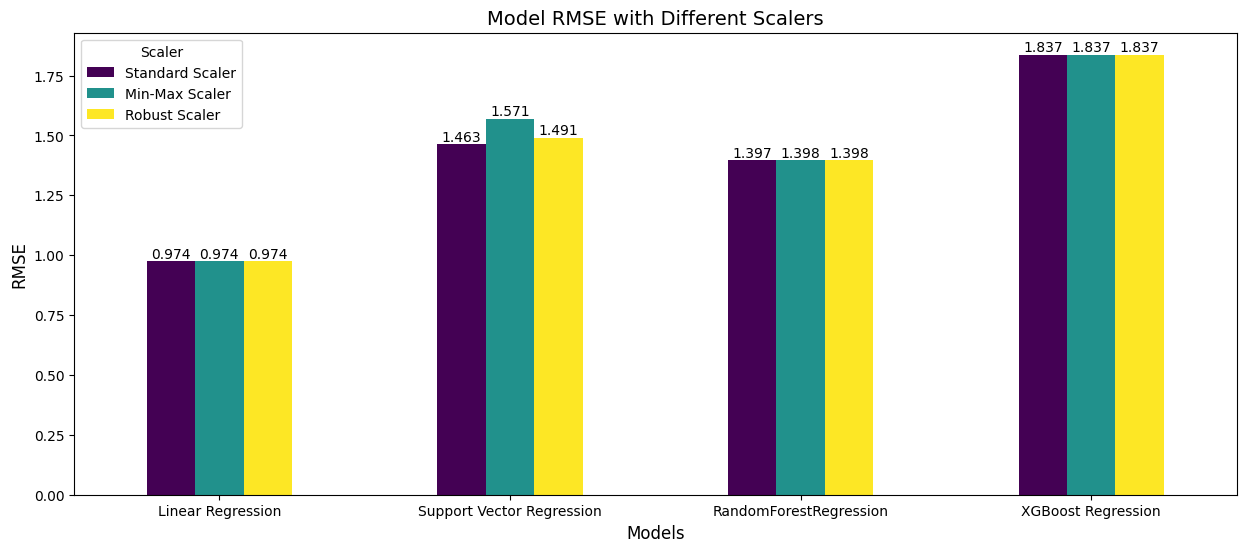

In [41]:
# Plotting RMSE Scores
ax = rmse_df.plot(kind='bar', figsize=(15, 6), colormap='viridis')
plt.title('Model RMSE with Different Scalers', fontsize=14)
plt.ylabel('RMSE', fontsize=12)
plt.xlabel('Models', fontsize=12)
plt.xticks(rotation=0)
plt.legend(title="Scaler", fontsize=10)

# Add text labels on top of each bar
for container in ax.containers:
    ax.bar_label(container, fmt='%.3f', label_type='edge', fontsize=10)